## Notebook setup

In [2]:
import os
import io
import warnings
import datetime
import numpy as np
import base64

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

from IPython.display import HTML

# import sys
# sys.path.append('../../')

from openbb_terminal.api import widgets
from openbb_terminal.api import openbb
from openbb_terminal.helper_classes import TerminalStyle

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
warnings.filterwarnings("ignore")

WARNING! Breaking changes incoming! Especially avoid using kwargs, since some of them will change.
You can try <link> branch with the latest changes.


In [ ]:
try:
    theme = TerminalStyle("light", "light", "light")
except:
    pass
stylesheet = widgets.html_report_stylesheet()
with open("./openbb_terminal/reports/OpenBB_reports_logo.png", "rb") as image_file:
    openbb_image_encoded = base64.b64encode(image_file.read())

## Select Ticker

In [3]:
# Parameters that will be replaced when calling this notebook
ticker = "EURUSD"
report_name = ""

In [4]:
author = "Henrique Joaquim"
report_title = f"INVESTMENT RESEARCH REPORT ON {ticker.upper()}"
report_date = datetime.datetime.now().strftime("%d %B, %Y")
report_time = datetime.datetime.now().strftime("%H:%M")
report_timezone = datetime.datetime.now(datetime.timezone.utc).astimezone().tzinfo
report_title, report_date, report_time, report_timezone

('INVESTMENT RESEARCH REPORT ON EURUSD',
 '25 August, 2022',
 '23:17',
 datetime.timezone(datetime.timedelta(seconds=3600), 'WEST'))

In [5]:
from_symbol = ticker[:3]
to_symbol = ticker[3:]
last_year = datetime.datetime.now() - datetime.timedelta(days=365)

ticker_data = openbb.forex.load(
    from_symbol=from_symbol,
    to_symbol=to_symbol,
    start_date=last_year.strftime("%Y-%m-%d"),
    interval="1day",
    resolution="d",
)

# 1 year historical data
ticker_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-08-25,1.175503,1.176055,1.172855,1.175309,1.175309,0
2021-08-26,1.177300,1.178134,1.174784,1.177440,1.177440,0
2021-08-27,1.175295,1.180359,1.173599,1.175641,1.175641,0
2021-08-30,1.179997,1.181195,1.178453,1.179901,1.179901,0
2021-08-31,1.179941,1.184553,1.179649,1.179690,1.179690,0
...,...,...,...,...,...,...
2022-08-19,1.008990,1.011225,1.003623,1.008990,1.008990,0
2022-08-22,1.003522,1.004823,0.992773,1.003522,1.003522,0
2022-08-23,0.993947,1.001904,0.990315,0.993947,0.993947,0


## Data

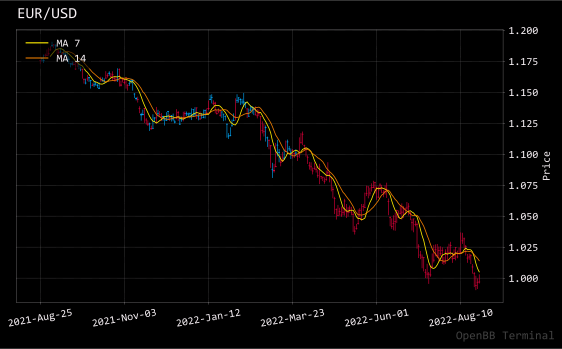

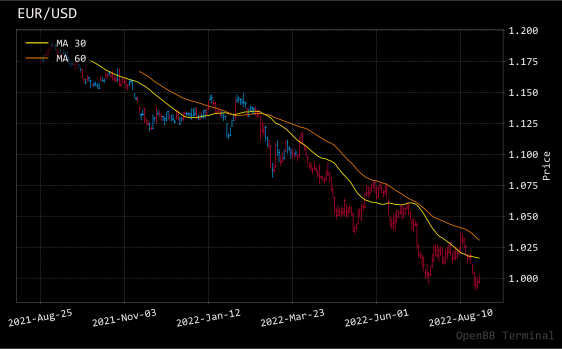

(None, None)

In [6]:
candle_ma_7_14 = openbb.forex.candle(
    data=ticker_data,
    to_symbol=to_symbol,
    from_symbol=from_symbol,
    ma=[7, 14],
    chart=True,
)

candle_ma_30_60 = openbb.forex.candle(
    data=ticker_data,
    to_symbol=to_symbol,
    from_symbol=from_symbol,
    ma=[30, 60],
    chart=True,
)

# candle graph with moving averages 7/14 and 30/60
candle_ma_7_14, candle_ma_30_60

In [7]:
fwd = openbb.forex.oanda.fwd(
    to_symbol=to_symbol,
    from_symbol=from_symbol,
)

# forward rates
fwd

,Ask,Bid,Mid,Points
Expiration,,,,
Overnight,0.99771,0.99763,0.99767,1.9400
Tomorrow Next,0.99758,0.99750,0.99754,0.6450
Spot Next,0.99758,0.99751,0.99754,0.6495
One Week,0.99798,0.99790,0.99794,4.6200
Two Weeks,0.99844,0.99835,0.99840,9.2300
Three Weeks,0.99885,0.99876,0.99881,13.3200
One Month,0.99954,0.99940,0.99947,19.9305
Two Months,1.00185,1.00175,1.00180,43.2000
Three Months,1.00413,1.00387,1.00400,65.2490


# Technical analysis

                Open      High       Low     Close  Adj Close  Volume
date                                                                 
2021-08-25  1.175503  1.176055  1.172855  1.175309   1.175309       0
2021-08-26  1.177300  1.178134  1.174784  1.177440   1.177440       0
2021-08-27  1.175295  1.180359  1.173599  1.175641   1.175641       0
2021-08-30  1.179997  1.181195  1.178453  1.179901   1.179901       0
2021-08-31  1.179941  1.184553  1.179649  1.179690   1.179690       0
...              ...       ...       ...       ...        ...     ...
2022-08-19  1.008990  1.011225  1.003623  1.008990   1.008990       0
2022-08-22  1.003522  1.004823  0.992773  1.003522   1.003522       0
2022-08-23  0.993947  1.001904  0.990315  0.993947   0.993947       0
2022-08-24  0.996691  0.999820  0.991198  0.996691   0.996691       0
2022-08-25  0.996910  1.003059  0.995679  0.996910   0.996910       0

[262 rows x 6 columns]


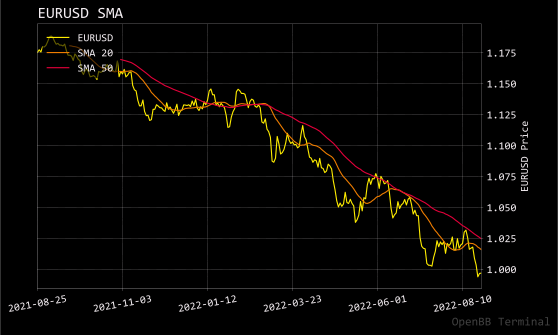

In [18]:
# simple moving average
ticker_data.index.names = ['date']

sma = openbb.common.ta.ma(
    data=ticker_data["Close"],
    ma_type="SMA",
    symbol=ticker,
    chart=True,
)

sma

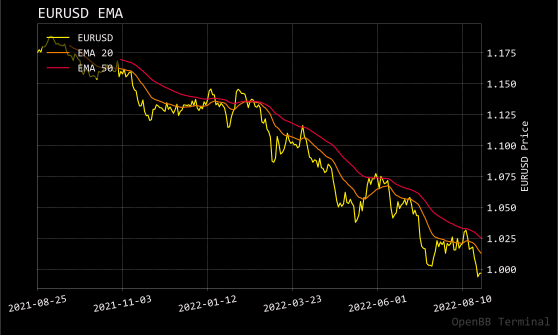

In [19]:
# exponential moving average

ema = openbb.common.ta.ma(
    data=ticker_data["Close"],
    ma_type="EMA",
    symbol=ticker,
    chart=True,
)

ema

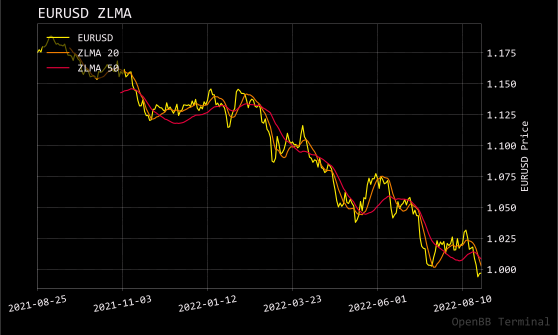

In [20]:
# zero lag exponential moving average

zlma = openbb.common.ta.ma(
    data=ticker_data["Close"],
    ma_type="ZLMA",
    symbol=ticker,
    chart=True,
)

zlma

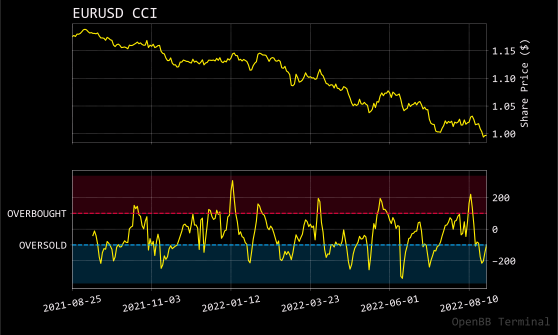

In [21]:
# commodity channel index

cci = openbb.common.ta.cci(
    data=ticker_data,
    symbol=ticker,
    chart=True,
)

cci

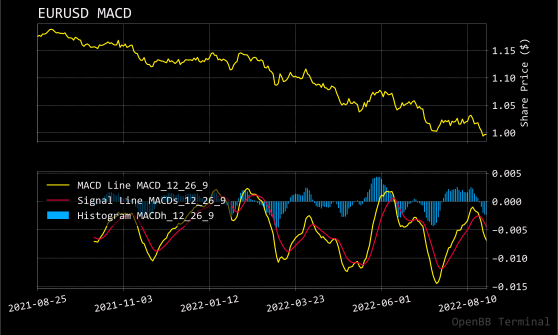

In [23]:
# moving average convergence/divergence

macd = openbb.common.ta.macd(
    series=ticker_data["Adj Close"],
    symbol=ticker,
    chart=True,
)

macd

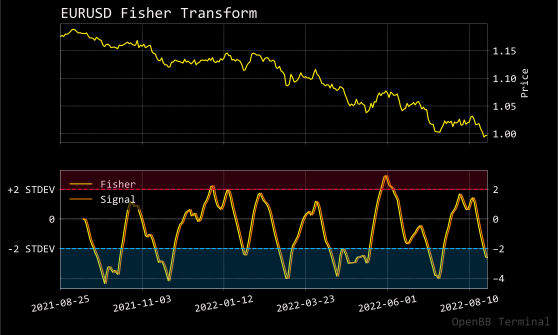

In [24]:
# fisher transform

fisher = openbb.common.ta.fisher(
    data=ticker_data,
    symbol=ticker,
    chart=True,
)

fisher

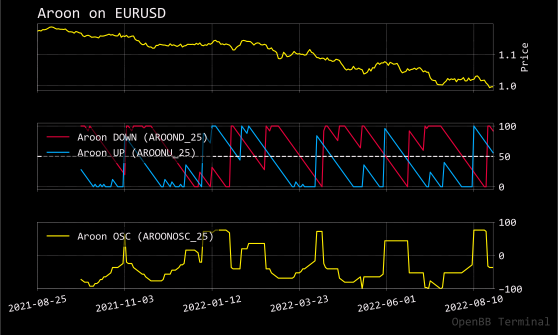

In [25]:
# aroon indicator

aroon = openbb.common.ta.aroon(
    data=ticker_data,
    symbol=ticker,
    chart=True,
)

aroon

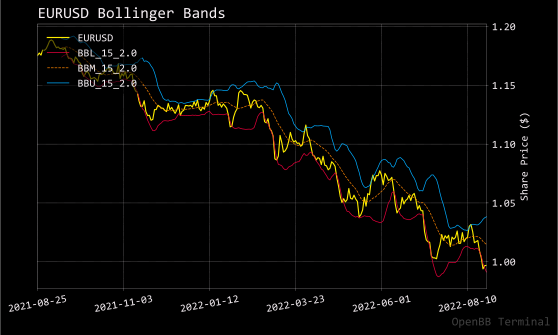

In [27]:
# bollinger bands

bbands = openbb.common.ta.bbands(
    data=ticker_data,
    symbol=ticker,
    chart=True,
)

bbands

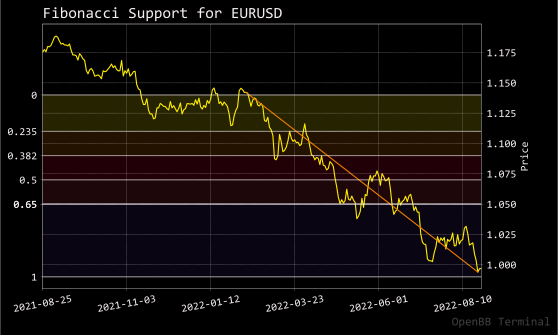

Fibonacci retracement levels
┏━━━━━━━━━━━┳━━━━━━━┓
┃ Fib Level ┃ Price ┃
┡━━━━━━━━━━━╇━━━━━━━┩
│ 0.0%      │ 1.14  │
├───────────┼───────┤
│ 23.5%     │ 1.11  │
├───────────┼───────┤
│ 38.2%     │ 1.09  │
├───────────┼───────┤
│ 50.0%     │ 1.07  │
├───────────┼───────┤
│ 61.8%     │ 1.05  │
├───────────┼───────┤
│ 65.0%     │ 1.05  │
├───────────┼───────┤
│ 100.0%    │ 0.99  │
└───────────┴───────┘

In [28]:
# fibonacci retracement

fib = openbb.common.ta.fib(
    data=ticker_data,
    symbol=ticker,
    chart=True,
)

fib

# Quantitative Analysis

In [30]:
# summary

summary = openbb.common.qa.summary(data=ticker_data)
summary

,Open,High,Low,Close,Adj Close,Volume
count,262.000000,262.000000,262.000000,262.000000,262.000000,262.0
mean,1.103349,1.106804,1.099388,1.103363,1.103363,0.0
std,0.052609,0.051821,0.053509,0.052622,0.052622,0.0
min,0.993947,0.999820,0.990315,0.993947,0.993947,0.0
10%,1.020835,1.025748,1.016228,1.020835,1.020835,0.0
25%,1.056454,1.059850,1.050724,1.056454,1.056454,0.0
50%,1.119890,1.123836,1.113834,1.119683,1.119683,0.0
75%,1.141908,1.144977,1.139008,1.141983,1.141983,0.0
90%,1.168061,1.169198,1.162193,1.168075,1.168075,0.0
max,1.188594,1.190760,1.186817,1.188594,1.188594,0.0


In [33]:
# normality statistics and tests

normality = openbb.common.qa.normality(
    data=ticker_data,
    target="Close",
    chart=True,
)
normality

                Normality Statistics                 
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃                    ┃ Statistic          ┃ p-value ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Kurtosis           │ -7.620151905828819 │ 0.0     │
├────────────────────┼────────────────────┼─────────┤
│ Skewness           │ -2.281132317481016 │ 0.0225  │
├────────────────────┼────────────────────┼─────────┤
│ Jarque-Bera        │ 17.07484517674703  │ 0.0002  │
├────────────────────┼────────────────────┼─────────┤
│ Shapiro-Wilk       │ 0.9448224902153015 │ 0.0     │
├────────────────────┼────────────────────┼─────────┤
│ Kolmogorov-Smirnov │ 0.839875613588354  │ 0.0     │
└────────────────────┴────────────────────┴─────────┘

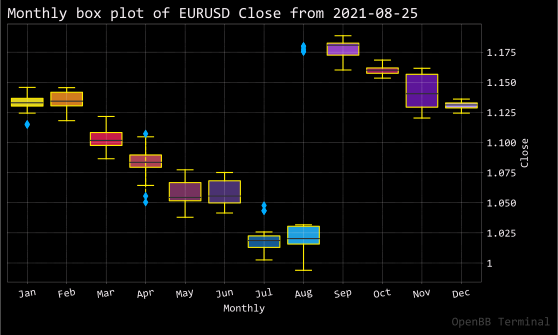

In [35]:
# box and whisker plot

bw = openbb.common.qa.bw(
    symbol=ticker,
    data=ticker_data,
    target="Close",
    yearly=False,
    chart=True,
)

bw

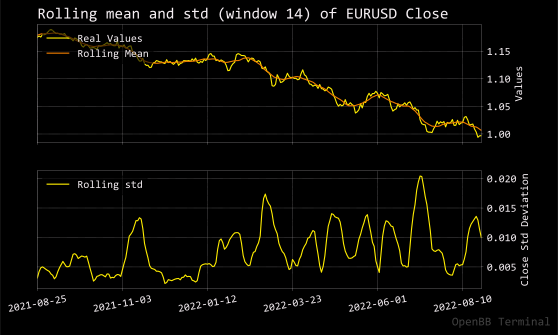

In [37]:
# rolling mean and std deviation of prices

rolling = openbb.common.qa.rolling(
    symbol=ticker,
    data=ticker_data,
    target="Close",
    chart=True,
)

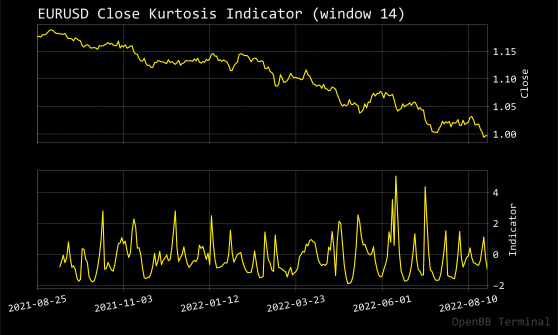

In [38]:
# rolling kurtosis of distribution of prices

kurtosis = openbb.common.qa.kurtosis(
    symbol=ticker,
    data=ticker_data,
    target="Close",
    chart=True,
)
kurtosis

In [39]:
# TODO: add prediction

## Render the report template to a file

In [ ]:
body = ""

img = f'<img src="data:image/png;base64,{openbb_image_encoded.decode()}" alt="OpenBB" style="width:144px;">'
body += widgets.header(
    img,
    author,
    report_date,
    report_time,
    report_timezone,
    f"<b>INVESTMENT RESEARCH REPORT:</b> {ticker}",
)

body += widgets.tablinks(
    [
        "SUMMARY",
        "Overview",
        "Analyst Opinions",
        "Fundamental Analysis",
        "Dark Pool and Shorts",
        "Technical Analysis",
        "Insider Trading",
        "Behavioural Analysis",
        "Quantitative Analysis",
        "Prediction Techniques",
    ]
)

htmlcode = widgets.h(3, "KPIs")
htmlcode += widgets.kpi(
    [last_price],
    [
        "Last closing price is above the average price ratings of last 30 days",
        "Average price ratings of last 30 day is above last closing price",
    ],
    avg_ratings_last_30_days,
)
if predictions:
    htmlcode += widgets.kpi(
        [0],
        [
            "Regression (dollars per market day) on last 30 market days is negative",
            "Regression (dollars per market day) on last 30 market days is positive",
        ],
        regression_slope,
    )
htmlcode += widgets.kpi(
    [30, 70],
    ["RSI level is oversold", "RSI level is normal", "RSI level is overbought"],
    rsi_value,
)
htmlcode += widgets.kpi(
    [0],
    [
        "The sum of last 10 insider trading (in millions) was negative",
        "The sum of last 10 insider trading (in millions) was positive",
    ],
    last_10_insider_trading,
)
htmlcode += widgets.kpi(
    [-0.1, 0.1],
    [
        "Last FinBrain sentiment is bearish",
        " Last FinBrain sentiment is neutral",
        "Last FinBrain sentiment is bullish",
    ],
    finbrain_sentiment_val,
)
if predictions:
    htmlcode += widgets.kpi(
        [0],
        [
            "The regression for the next 20th market price is below closing price",
            "The regression for the next 20th market price is above closing price",
        ],
        round(regression_val - last_price, 2),
    )
body += widgets.add_tab("SUMMARY", htmlcode)

htmlcode = widgets.row([price_chart])
htmlcode += widgets.row(
    [widgets.h(3, "Description") + widgets.p(overview)]
)
body += widgets.add_tab("Overview", htmlcode)

htmlcode = widgets.row([price_target_chart])
htmlcode += widgets.row([ratings_over_time_chart])
htmlcode += widgets.row([df_analyst.to_html()])
body += widgets.add_tab("Analyst Opinions", htmlcode)

htmlcode = widgets.row(
    [widgets.h(3, "Estimates") + df_year_estimates.head().to_html()]
)
htmlcode += widgets.row(
    [widgets.h(3, "Earnings") + df_quarter_earnings.head().to_html()]
)
htmlcode += widgets.row(
    [widgets.h(3, "Revenues") + df_quarter_revenues.head().to_html()]
)
htmlcode += widgets.row(
    [widgets.h(3, "SEC filings") + df_sec_filings.to_html(escape=False)]
)
body += widgets.add_tab("Fundamental Analysis", htmlcode)

htmlcode = widgets.row([net_short_position])
htmlcode += widgets.row([price_vs_short_interest])
htmlcode += widgets.row([dark_pools])
body += widgets.add_tab("Dark Pool and Shorts", htmlcode)

body += widgets.add_tab("Technical Analysis", widgets.row([ta_rsi]))

htmlcode = widgets.row(
    [
        widgets.h(3, "Last Activity")
        + df_insider.head(10).to_html(col_space="75px")
    ]
)
body += widgets.add_tab("Insider Trading", htmlcode)

htmlcode = widgets.row([finbrain_sentiment])
htmlcode += widgets.row([snews])
htmlcode += widgets.row(
    [widgets.h(3, "Stocktwits") + stocktwits_sentiment]
)
body += widgets.add_tab("Behavioural Analysis", htmlcode)

# Deprecated in the new API
# htmlcode = widgets.row([bw_month])
# htmlcode += widgets.row([bw_year])
# body += widgets.add_tab("Quantitative Analysis", htmlcode)

if predictions:
    htmlcode = widgets.row([regression])
    htmlcode += widgets.row([mc])
else:
    htmlcode = widgets.row(["Prediction features not enabled."])
body += widgets.add_tab("Prediction Techniques", htmlcode)

body += widgets.tab_clickable_evt()

report = widgets.html_report(title=report_name, stylesheet=stylesheet, body=body)

# to save the results
with open(report_name + ".html", "w", encoding="utf-8") as fh:
    fh.write(report)